# Linear Regression:

In [46]:
import pandas as pd
import numpy as np
%matplotlib inline
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

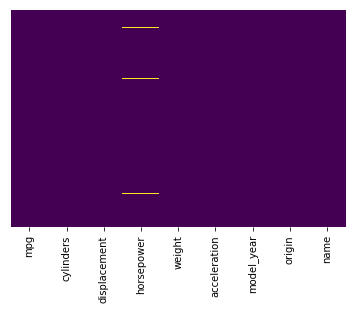

In [2]:
df = pd.read_csv("mpg.csv")
df= df.replace('?', np.NaN)
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [3]:
df.dropna(inplace=True)
df['horsepower']=df['horsepower'].astype("float")
df.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,1.576531
std,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,0.805518
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,1.000000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


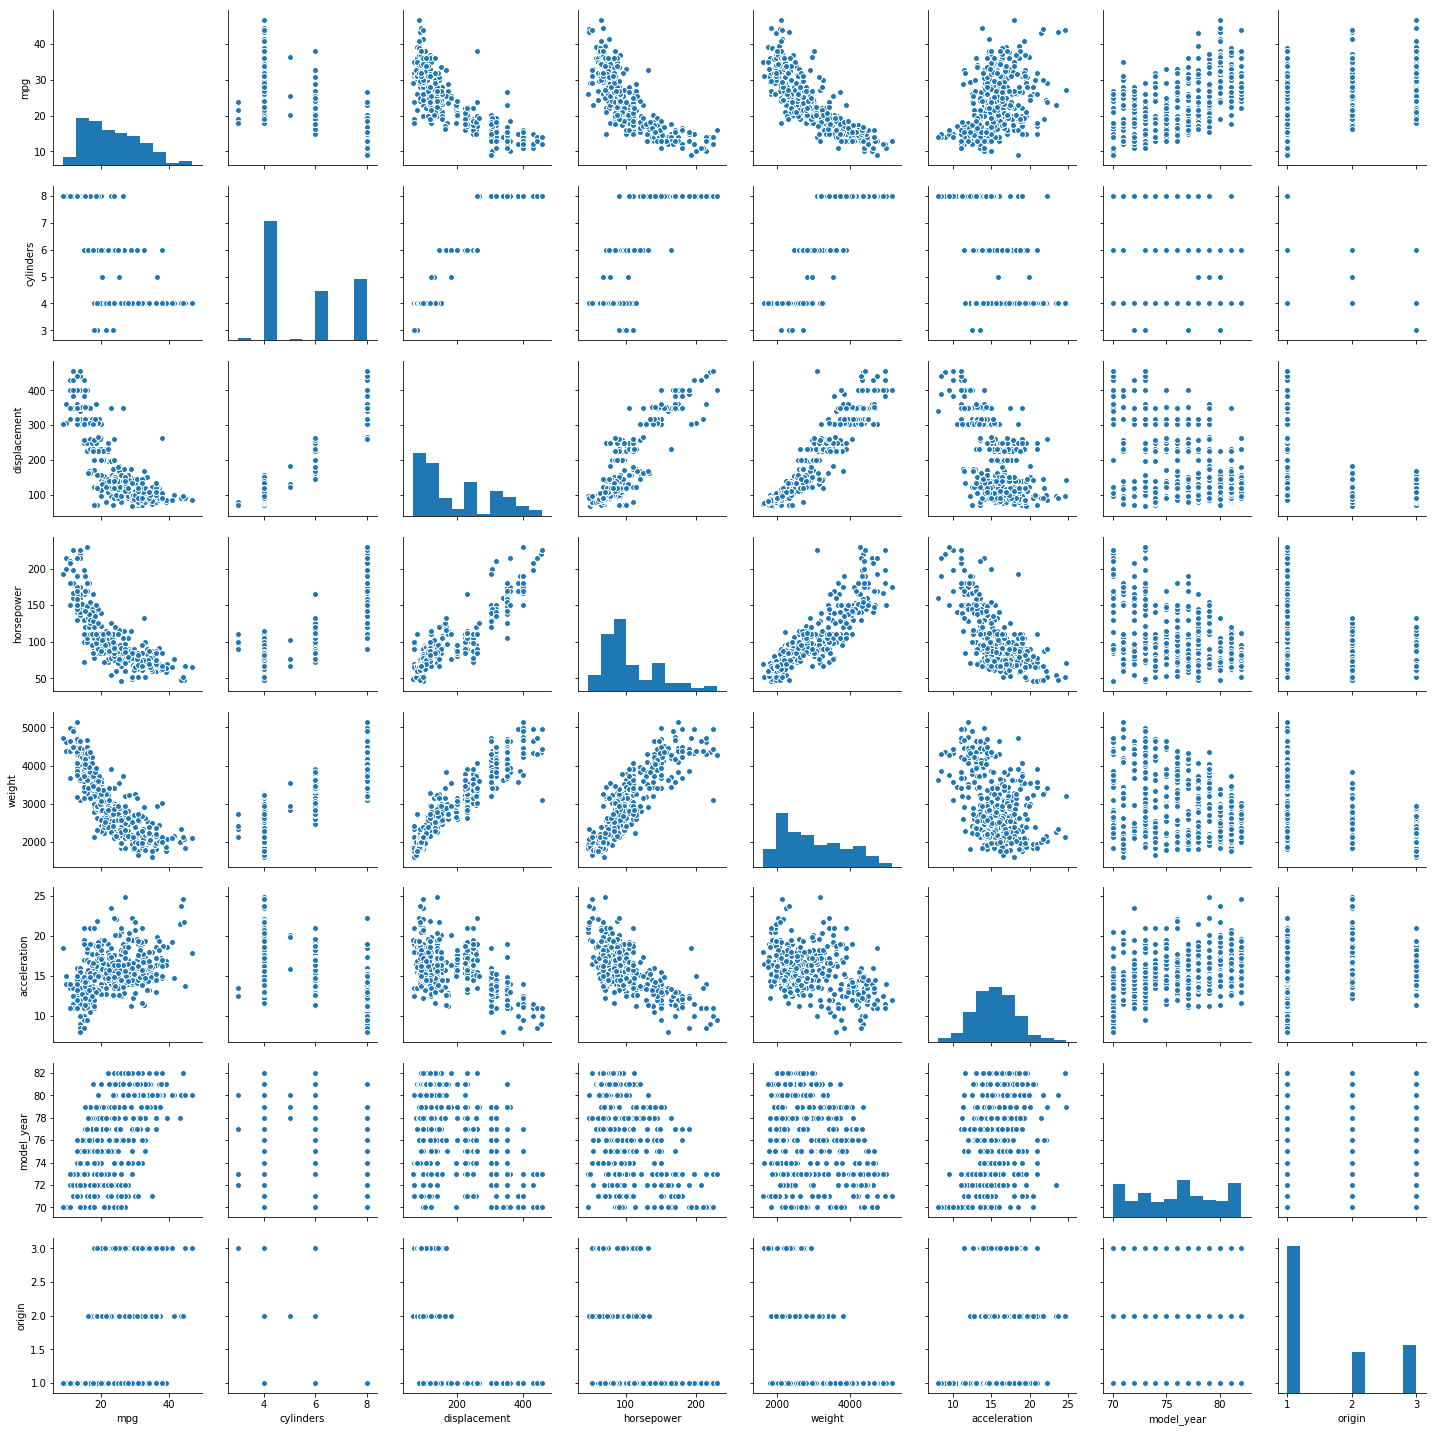

In [4]:
sns.pairplot(df)

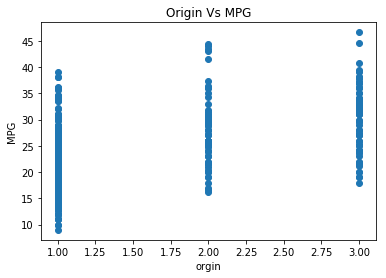

In [5]:
plt.title("Origin Vs MPG")
plt.xlabel("orgin");
plt.ylabel("MPG");
plt.scatter(df['origin'], df['mpg']);

## As we can see, Car origin has no impact on MPG


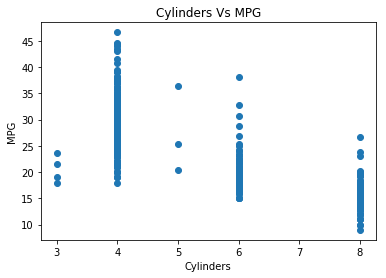

In [6]:
plt.xlabel("Cylinders");
plt.title("Cylinders Vs MPG")
plt.ylabel("MPG");
plt.scatter(df['cylinders'], df['mpg']);

## Relation vetween Cylinders Vs MPG ?

## Maybe. Let's ignore 'cylinder' column for now.

## Now making a copy of df instead of overwriting it


In [7]:
df2 = df[['mpg', 'displacement', 'horsepower', 'weight', 'acceleration']].copy()
df2.head()

,mpg,displacement,horsepower,weight,acceleration
0,18.0,307.0,130.0,3504,12.0
1,15.0,350.0,165.0,3693,11.5
2,18.0,318.0,150.0,3436,11.0
3,16.0,304.0,150.0,3433,12.0
4,17.0,302.0,140.0,3449,10.5


## Skewness Check for target Variable = MPG

Text(0,0.5,'Frequency')

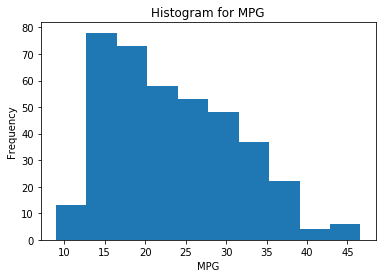

In [8]:
plt.hist(df2['mpg'], bins=10)
plt.title("Histogram for MPG")
plt.xlabel("MPG")
plt.ylabel("Frequency")

## Looks right-skewed. Perform Box-Cox transformation.
## To make data Normal


Text(0,0.5,'Frequency')

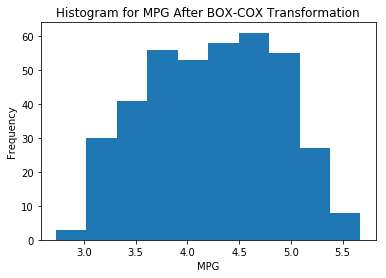

In [9]:
Transformed_Array = stats.boxcox(df2['mpg'])[0]
plt.hist(Transformed_Array, bins=10);
plt.title("Histogram for MPG After BOX-COX Transformation")
plt.xlabel("MPG")
plt.ylabel("Frequency")

## Performed the Shapiro-Wilk test for normality.


In [10]:
print("Shapiro test statistic = {}".format(stats.shapiro(Transformed_Array)[0]))
print("Shapiro p-VAl = {}".format(stats.shapiro(Transformed_Array)[1]))

Shapiro test statistic = 0.9828928709030151
Shapiro p-VAl = 0.00013592593313660473


## Looks pretty good despite low Shapiro-Wilk score.
## Make some plots to see how response depends on predictors


Text(0,0.5,'Displacement')

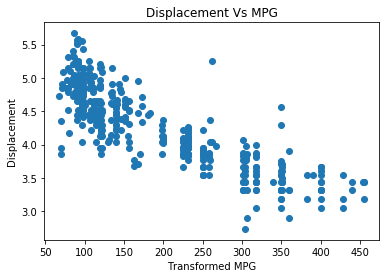

In [11]:
plt.scatter(df2['displacement'], Transformed_Array);
plt.title("Displacement Vs MPG")
plt.xlabel("Transformed MPG")
plt.ylabel("Displacement")

Text(0,0.5,'Horsepower')

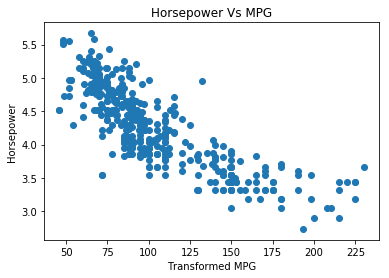

In [12]:
plt.scatter(df2['horsepower'], Transformed_Array);
plt.title("Horsepower Vs MPG")
plt.xlabel("Transformed MPG")
plt.ylabel("Horsepower")

Text(0,0.5,'Weight')

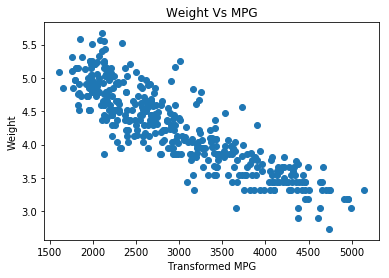

In [13]:
plt.scatter(df2['weight'], Transformed_Array);
plt.title("Weight Vs MPG")
plt.xlabel("Transformed MPG")
plt.ylabel("Weight")

Text(0,0.5,'Acceleration')

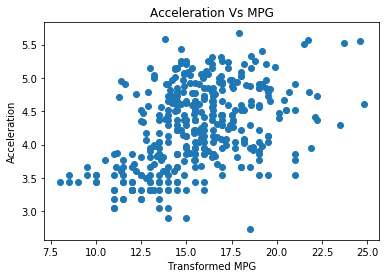

In [14]:
plt.scatter(df2['acceleration'], Transformed_Array);
plt.title("Acceleration Vs MPG")
plt.xlabel("Transformed MPG")
plt.ylabel("Acceleration")

## MPG seems to depend on inverse powers of 'displacement, horsepower and weight'

## So, we can create new columns with their inverses and use these new columns with PolynomialFeatures. 

## Acceleration doesn't look predictive; for a given x value, the y values span the range of y


In [15]:
# create 'inverse' columns and add transformed response column
for col in df2.columns[1:4]:
    df2.loc[:, 'inv_'+col] = 1. / df2.loc[:, col]
df2.loc[:, 'boxcox_mpg'] = Transformed_Array
df2.head()


,mpg,displacement,horsepower,weight,acceleration,inv_displacement,inv_horsepower,inv_weight,boxcox_mpg
0,18.0,307.0,130.0,3504,12.0,0.003257,0.007692,0.000285,3.859148
1,15.0,350.0,165.0,3693,11.5,0.002857,0.006061,0.000271,3.547736
2,18.0,318.0,150.0,3436,11.0,0.003145,0.006667,0.000291,3.859148
3,16.0,304.0,150.0,3433,12.0,0.003289,0.006667,0.000291,3.656731
4,17.0,302.0,140.0,3449,10.5,0.003311,0.007143,0.000290,3.760348


## Center and standardize columns
## Split data into train/test sets and find mean/variance of train set for scaling


In [78]:
feature = ['inv_displacement', 'inv_horsepower', 'inv_weight']
response = ['boxcox_mpg']

X_train, X_test, y_train, y_test = train_test_split(df2[feature], df2[response], test_size=0.333, random_state=101)

# obtain scalers and perform scaling, including the test sets
scalerX = preprocessing.StandardScaler().fit(X_train)
scalery = preprocessing.StandardScaler().fit(y_train)

X_train_scaled = scalerX.transform(X_train)
X_test_scaled = scalerX.transform(X_test)
y_train_scaled = scalery.transform(y_train)
y_test_scaled = scalery.transform(y_test)

# Construct regression model

In [74]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model = make_pipeline(preprocessing.PolynomialFeatures(2, interaction_only=False), \
                      LinearRegression())

# fit model and score it based on r^2
model.fit(X_train_scaled, y_train_scaled);
y_pred_scaled = model.predict(X_test_scaled)
model.score(X_test_scaled, y_test_scaled)

0.80704819311150167

## Pretty good r^2


## Which predictors were used ?


In [20]:
print("\n")
print("--------feature Names and Coefficients-----")
print("\n")
count = 1
for features in model.steps[0][1].get_feature_names(input_features=feature):
    print("{}.) {} =  {}".format(count,features, model.steps[1][1].coef_[0][count-1]))
    count+=1
    print("\n")



--------feature Names and Coefficients-----


1.) 1 =  0.0


2.) inv_displacement =  0.25702103260129483


3.) inv_horsepower =  0.31002255323442424


4.) inv_weight =  0.37769987980354436


5.) inv_displacement^2 =  -0.2094443013818217


6.) inv_displacement inv_horsepower =  0.6102435167898861


7.) inv_displacement inv_weight =  -0.30884566177432443


8.) inv_horsepower^2 =  -0.11416709434742194


9.) inv_horsepower inv_weight =  -0.4175336053573188


10.) inv_weight^2 =  0.21866028617290775




In [21]:
model.steps[1][1].intercept_

array([ 0.24247078])

## Make some plots to visualize accuracy of model predictions


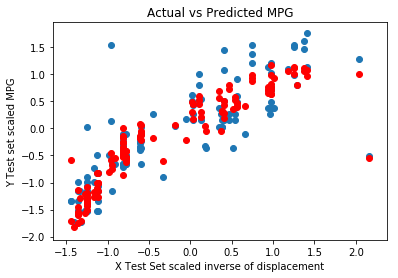

In [22]:
col = 0 # inv_displacement
plt.title("Actual vs Predicted MPG")
plt.xlabel("X Test Set scaled inverse of displacement")
plt.ylabel("Y Test set scaled MPG")
plt.scatter(X_test_scaled[:, col], y_test_scaled);
plt.scatter(X_test_scaled[:, col], y_pred_scaled, c='r');

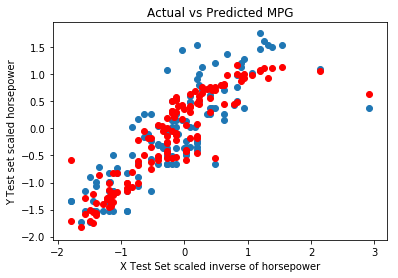

In [23]:

col = 1 # inv_horsepower
plt.title("Actual vs Predicted MPG")
plt.xlabel("X Test Set scaled inverse of horsepower")
plt.ylabel("Y Test set scaled horsepower")
plt.scatter(X_test_scaled[:, col], y_test_scaled);
plt.scatter(X_test_scaled[:, col], y_pred_scaled, c='r');

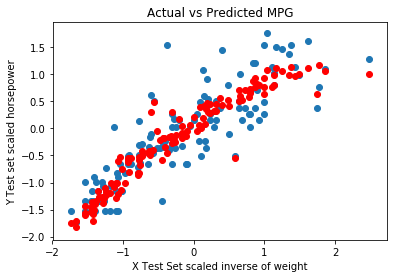

In [24]:

col = 2 # inv_weight
plt.title("Actual vs Predicted MPG")
plt.xlabel("X Test Set scaled inverse of weight")
plt.ylabel("Y Test set scaled horsepower")
plt.scatter(X_test_scaled[:, col], y_test_scaled);
plt.scatter(X_test_scaled[:, col], y_pred_scaled, c='r');

## Make a residual plot as a last check

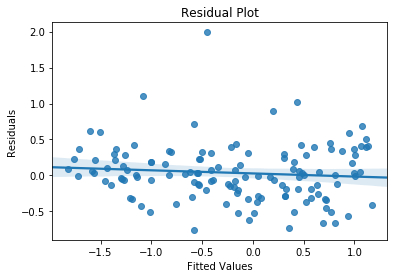

In [25]:
ax = sns.regplot(y_pred_scaled[:,0], y_test_scaled[:,0]-y_pred_scaled[:,0]);
ax.set(xlabel='Fitted Values', ylabel='Residuals', title='Residual Plot')
plt.show();

### Predictions from our Model

Text(0.5,1,'Y Predicted Vs Y Actual')

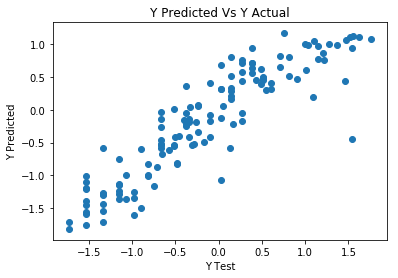

In [26]:
plt.scatter(y_test_scaled,y_pred_scaled)
plt.xlabel("Y Test")
plt.ylabel("Y Predicted")
plt.title("Y Predicted Vs Y Actual")

### Residual Histogram

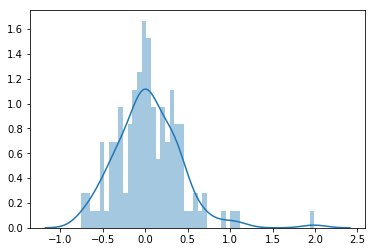

In [27]:
sns.distplot((y_test_scaled-y_pred_scaled),bins=50);

### MODEL 1

In [28]:
print('MAE:', metrics.mean_absolute_error(y_test_scaled, y_pred_scaled))
print('MSE:', metrics.mean_squared_error(y_test_scaled, y_pred_scaled))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test_scaled, predictions)))

MAE: 0.284498711702
MSE: 0.151771439059
RMSE: 0.389578540296


# Does reducing multicollinearity improves prediction ?

In [29]:
from scipy.stats import pearsonr

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

### Correlation Matrix

In [30]:
df.corr()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
mpg,1.000000,-0.777618,-0.805127,-0.778427,-0.832244,0.423329,0.580541,0.565209
cylinders,-0.777618,1.000000,0.950823,0.842983,0.897527,-0.504683,-0.345647,-0.568932
displacement,-0.805127,0.950823,1.000000,0.897257,0.932994,-0.543800,-0.369855,-0.614535
horsepower,-0.778427,0.842983,0.897257,1.000000,0.864538,-0.689196,-0.416361,-0.455171
weight,-0.832244,0.897527,0.932994,0.864538,1.000000,-0.416839,-0.309120,-0.585005
acceleration,0.423329,-0.504683,-0.543800,-0.689196,-0.416839,1.000000,0.290316,0.212746
model_year,0.580541,-0.345647,-0.369855,-0.416361,-0.309120,0.290316,1.000000,0.181528
origin,0.565209,-0.568932,-0.614535,-0.455171,-0.585005,0.212746,0.181528,1.000000


### A lot of features are highly correlated, but are these statistically significant ?
### p-values shoes they are ...
### Correlation Matrix P- Values

In [31]:
calculate_pvalues(df)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
mpg,0,0,0,0,0,0,0,0
cylinders,0,0,0,0,0,0,0,0
displacement,0,0,0,0,0,0,0,0
horsepower,0,0,0,0,0,0,0,0
weight,0,0,0,0,0,0,0,0
acceleration,0,0,0,0,0,0,0,0
model_year,0,0,0,0,0,0,0,0.0003
origin,0,0,0,0,0,0,0.0003,0


In [126]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [116]:
df_new = pd.read_csv("mpg.csv")
df_new= df_new.replace('?', np.NaN)
df_new.dropna(inplace=True)
df_new['horsepower']=df_new['horsepower'].astype("float")

In [117]:
df_new = df_new._get_numeric_data() #drop non-numeric cols
df_new = df_new.drop(['mpg'],1)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df_new.values, i) for i in range(df_new.shape[1])]
vif["features"] = df_new.columns
vif.round(1)


,VIF Factor,features
0,117.7,cylinders
1,96.9,displacement
2,67.1,horsepower
3,139.5,weight
4,69.7,acceleration
5,115.8,model_year
6,8.5,origin


In [118]:
df_new = df_new._get_numeric_data() #drop non-numeric cols
df_new.drop("cylinders",axis=1,inplace=True)
df_new.drop("acceleration",axis=1,inplace=True)
df_new.drop("origin",axis=1,inplace=True)
df_new.drop("displacement",axis=1,inplace=True)
#df_new.drop("weight",axis=1,inplace=True)
df_new.drop("model_year",axis=1,inplace=True)
#df_new.drop("horsepower",axis=1,inplace=True)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df_new.values, i) for i in range(df_new.shape[1])]
vif["features"] = df_new.columns
vif.round(1)

,VIF Factor,features
0,32.2,horsepower
1,32.2,weight


# So we end up removing every parameter except weight

In [120]:
feature = ['weight']
response = ['boxcox_mpg']

X_train, X_test, y_train, y_test = train_test_split(df2[feature], df2[response], test_size=0.333, random_state=101)

# obtain scalers and perform scaling, including the test sets
scalerX = preprocessing.StandardScaler().fit(X_train)
scalery = preprocessing.StandardScaler().fit(y_train)

X_train_scaled = scalerX.transform(X_train)
X_test_scaled = scalerX.transform(X_test)
y_train_scaled = scalery.transform(y_train)
y_test_scaled = scalery.transform(y_test)

### MODEL 2

In [123]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model = make_pipeline(preprocessing.PolynomialFeatures(2, interaction_only=False), \
                      LinearRegression())

# fit model and score it based on r^2
model.fit(X_train_scaled, y_train_scaled);
y_pred_scaled = model.predict(X_test_scaled)
model.score(X_test_scaled, y_test_scaled)

0.75249588424192271

In [124]:
print("\n")
print("--------feature Names and Coefficients-----")
print("\n")
count = 1
for features in model.steps[0][1].get_feature_names(input_features=feature):
    print("{}.) {} =  {}".format(count,features, model.steps[1][1].coef_[0][count-1]))
    count+=1
    print("\n")



--------feature Names and Coefficients-----


1.) 1 =  0.0


2.) weight =  -0.904550169262238


3.) weight^2 =  0.05777702282202579




# But R^2 is not good enough to proceed 

## lets use Forward selection to choose parameters and then check

In [2]:
data = pd.read_csv("mpg.csv")
data= data.replace('?', np.NaN)
data.dropna(inplace=True)
data['horsepower']=data['horsepower'].astype("float")

In [3]:

def data_preparation(data): 
        
    cols = data.shape[1]  
    train, test = train_test_split(data, test_size=0.3,random_state=101)

    X_train=train.iloc[:,:cols-1]
    y_train=train.iloc[:,:1]
    
    X_test=test.iloc[:,:cols-1]
    y_test=test.iloc[:,:1]
    
    return X_train,X_test,y_train,y_test


In [4]:
X_train,X_test,y_train,y_test = data_preparation(data)

In [5]:
import statsmodels.formula.api as smf

remaining = set(X_train.columns)
remaining.remove('mpg')
response = 'mpg'
selected = []
current_score, best_new_score = 0.0, 0.0
while remaining and current_score == best_new_score:
    scores_with_candidates = []
    for candidate in remaining:
        formula = "{} ~ {} + 1".format(response,
                                       ' + '.join(selected + [candidate]))
        score = smf.ols(formula, data).fit().rsquared_adj
        scores_with_candidates.append((score, candidate))
    scores_with_candidates.sort()
    best_new_score, best_candidate = scores_with_candidates.pop()
    if current_score < best_new_score:
        remaining.remove(best_candidate)
        selected.append(best_candidate)
        current_score = best_new_score

In [6]:
formula = "{} ~ {} + 1".format(response,' + '.join(selected))
model = smf.ols(formula, X_test).fit()

In [7]:
formula

'mpg ~ weight + model_year + origin + displacement + horsepower + cylinders + 1'

In [8]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     88.20
Date:                Fri, 09 Mar 2018   Prob (F-statistic):           6.50e-40
Time:                        15:00:27   Log-Likelihood:                -296.77
No. Observations:                 118   AIC:                             607.5
Df Residuals:                     111   BIC:                             626.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -10.5514      6.977     -1.512      0.133     -24.376       3.274
weight          -0.0058      0.001     -6.521      0.000      -0.008      -0.004
model_year       0.6793      0.085      7.972      0.000       0.510       0.848
origin           1.9405      0.502      3.864      0.000       0.945       2.936
displacement     0.0327      0.014      2.345      0.021       0.005       0.060
horsepower      -0.0403      0.020     -2.001      0.048      -0.080      -0.000
cylinders       -1.0434      0.591     -1.764      0.080      -2.215       0.129
==============================================================================
Omnibus:                        6.075   Durbin-Watson:                   2.054
Prob(Omnibus):                  0.048   Jarque-Bera (JB):                5.749
Skew:                           0.534   Prob(JB):                       0.0564
Kurtosis:                       3.167   Cond. No.                     7.87e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.87e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Predictions from our Model


### MODEL 3

In [19]:
y_pred = model.predict(X_test)

print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 2.36685913743
MSE: 8.95346574885
RMSE: 2.9922342403


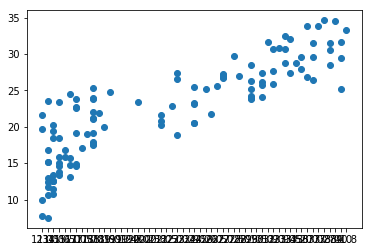

In [21]:
plt.scatter(y_test, y_pred)

### Residual Histogram

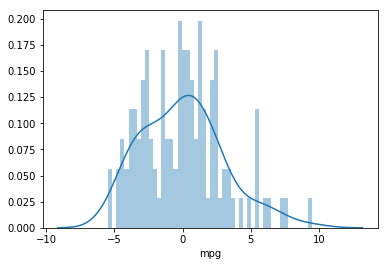

In [44]:
sns.distplot((y_test['mpg']-y_pred.values),bins=50);

## Removing Multicollinearity won't help in improving predictions.

# SO BEST MODEL WAS MODEL 1